In [1]:
# prelim libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold # same accuracy otherwise
from sklearn.metrics import accuracy_score, mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# load data 
path = os.path.join(os.pardir, 'data/regression_data', 'zillow_hvi.csv')
data = pd.read_csv(path)

In [3]:
# data understanding report script from CSC 373
text = "Data description:\n" + f"Shape: {data.shape}\n"
text += f"Duplicated rows: {data.duplicated().sum()}\n" + f"Number of rows with missing values: {data.isnull().any(axis=1).sum()}\n"
text += f"Number of columns with missing values: {data.isnull().any(axis=0).sum()}\n\n" + f"{data.dtypes.to_string()}\n\n" + f"{data.describe().T.to_string()}\n"
print(text)

Data description:
Shape: (895, 306)
Duplicated rows: 0
Number of rows with missing values: 595
Number of columns with missing values: 241

RegionID        int64
SizeRank        int64
RegionName     object
RegionType     object
StateName      object
2000-01-31    float64
2000-02-29    float64
2000-03-31    float64
2000-04-30    float64
2000-05-31    float64
2000-06-30    float64
2000-07-31    float64
2000-08-31    float64
2000-09-30    float64
2000-10-31    float64
2000-11-30    float64
2000-12-31    float64
2001-01-31    float64
2001-02-28    float64
2001-03-31    float64
2001-04-30    float64
2001-05-31    float64
2001-06-30    float64
2001-07-31    float64
2001-08-31    float64
2001-09-30    float64
2001-10-31    float64
2001-11-30    float64
2001-12-31    float64
2002-01-31    float64
2002-02-28    float64
2002-03-31    float64
2002-04-30    float64
2002-05-31    float64
2002-06-30    float64
2002-07-31    float64
2002-08-31    float64
2002-09-30    float64
2002-10-31    float64
200

In [4]:
# count nans in each column
null_counts = data.isnull().sum().sort_values(ascending=False)

# display columns with more than 10% nulls (adjustable threshold)
threshold = int(0.1 * len(data))  # 10% of total rows
high_null_cols = null_counts[null_counts > threshold]

print(f"Columns with >10% nulls ({len(high_null_cols)} columns):")
print(high_null_cols)

Columns with >10% nulls (144 columns):
2000-01-31    464
2000-02-29    463
2000-03-31    462
2000-04-30    460
2000-05-31    458
             ... 
2011-08-31    105
2011-11-30    105
2011-09-30    104
2011-10-31    104
2011-12-31    104
Length: 144, dtype: int64


In [5]:
## begin data preprocessing

# drop columns with >10% nulls (already identified)
data = data.drop(columns=high_null_cols.index)

# drop duplicate rows
data.drop_duplicates(inplace=True, keep='first')

# drop rows where target is null
data.dropna(subset=['2025-01-31'], inplace=True)

# drop columns with all missing values
data.dropna(how='all', axis=1, inplace=True)

# drop irrelevant features
data.drop(columns=['RegionID', 'RegionName'], inplace=True)

# drop rows with >10% missing
row_threshold = int(0.10 * data.shape[1])
data = data[data.isnull().sum(axis=1) <= row_threshold]

print(f"After row pruning - Shape: {data.shape}")
print(f"Rows with missing values: {data.isnull().any(axis=1).sum()}")
print(f"Columns with missing values: {data.isnull().any(axis=0).sum()}\n")

After row pruning - Shape: (846, 160)
Rows with missing values: 45
Columns with missing values: 33



In [6]:
# define target column: last date (2025-01-31)
target_col = '2025-01-31'

# separate X and y
X = data.drop(columns=[target_col])
y = data[target_col]

# confirm shapes
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (846, 159)
y shape: (846,)


In [7]:
# fill missing values forward, then backward
X = X.ffill(axis=1).bfill(axis=1).infer_objects(copy=False)

# confirm no nulls remain
print(f"Remaining nulls in X: {X.isnull().sum().sum()}")

Remaining nulls in X: 0


/var/folders/xw/015f2d5n37g0kf1j6cr6gymh0000gn/T/ipykernel_76772/482045507.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.ffill(axis=1).bfill(axis=1).infer_objects(copy=False)


In [8]:
## begin encoding
# separate feature types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# categorical features
from sklearn.preprocessing import LabelEncoder

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

unique_values = {col: X[col].nunique() for col in categorical_cols}

# numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [9]:
# reshape to 2D array
y = data.iloc[:, -1].values.reshape(-1, 1)

# now scale
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y)

# confirm shape
print(f"y shape: {y.shape}")  # Should be (895, 1)
print(f"y mean: {y.mean():.4f}, std: {y.std():.4f}")


y shape: (846, 1)
y mean: 0.0000, std: 1.0000


In [10]:
from sklearn.model_selection import train_test_split

# store feature groups
X_input_dict = {}

# add categorical features
for col in categorical_cols:
    X_input_dict[col] = X[col]

# add numerical features
X_input_dict['numerical_input'] = X[numerical_cols]

# split features and labels (80% train, 20% test)
X_train_dict = {}
X_test_dict = {}

# split categorical features
for col in categorical_cols:
    X_train_dict[col], X_test_dict[col] = train_test_split(X_input_dict[col], test_size=0.2, random_state=42)

# split numerical features
X_train_num, X_test_num = train_test_split(X_input_dict['numerical_input'], test_size=0.2, random_state=42)
X_train_dict['numerical_input'] = X_train_num
X_test_dict['numerical_input'] = X_test_num

# split labels
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

# sanity check
print(f"Train dict keys: {list(X_train_dict.keys())}")
print(f"X_train numerical shape: {X_train_dict['numerical_input'].shape}")
print(f"X_test numerical shape: {X_test_dict['numerical_input'].shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

Train dict keys: ['RegionType', 'StateName', '2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30', '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31', '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31', 'numerical_input']
X_train numerical shape: (676, 142)
X_test numerical shape: (170, 142)
y_train shape: (676, 1), y_test shape: (170, 1)


In [14]:
## baseline model
def build_model(hidden_units=[64, 32], activation='relu', optimizer='adam'):
    # numerical input
    num_input = keras.Input(shape=(X_train_dict['numerical_input'].shape[1],), name='numerical_input')

    # categorical inputs (label encoded)
    cat_inputs = []
    for col in categorical_cols:
        input_layer = keras.Input(shape=(1,), name=col)
        cat_inputs.append(input_layer)

    # concatenate inputs
    all_inputs = [num_input] + cat_inputs
    x = layers.Concatenate()(all_inputs)

    # dense Layers
    for units in hidden_units:
        x = layers.Dense(units, activation=activation)(x)

    # output Layer (regression)
    output = layers.Dense(1, activation='linear')(x)

    # build model
    model = keras.Model(inputs=all_inputs, outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


In [15]:
# model architecture
baseline_model = build_model()

# train model
history = baseline_model.fit(
    X_train_dict, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
17/17 [==============================] - 0s 6ms/step - loss: 939.0162 - mae: 21.2058 - val_loss: 139.6841 - val_mae: 9.2023
Epoch 2/20
17/17 [==============================] - 0s 2ms/step - loss: 82.2907 - mae: 6.5238 - val_loss: 50.6559 - val_mae: 4.8372
Epoch 3/20
17/17 [==============================] - 0s 2ms/step - loss: 23.0914 - mae: 2.8441 - val_loss: 42.8242 - val_mae: 3.1017
Epoch 4/20
17/17 [==============================] - 0s 2ms/step - loss: 12.3512 - mae: 2.0197 - val_loss: 38.0521 - val_mae: 2.4877
Epoch 5/20
17/17 [==============================] - 0s 2ms/step - loss: 7.6429 - mae: 1.5278 - val_loss: 33.0313 - val_mae: 1.9866
Epoch 6/20
17/17 [==============================] - 0s 2ms/step - loss: 5.3612 - mae: 1.0683 - val_loss: 30.8878 - val_mae: 1.8187
Epoch 7/20
17/17 [==============================] - 0s 2ms/step - loss: 4.6185 - mae: 0.9880 - val_loss: 28.4528 - val_mae: 1.6623
Epoch 8/20
17/17 [==============================] - 0s 2ms/step - loss: 2.87

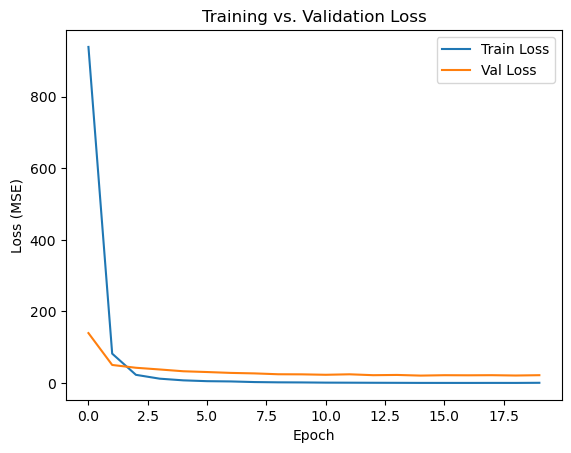

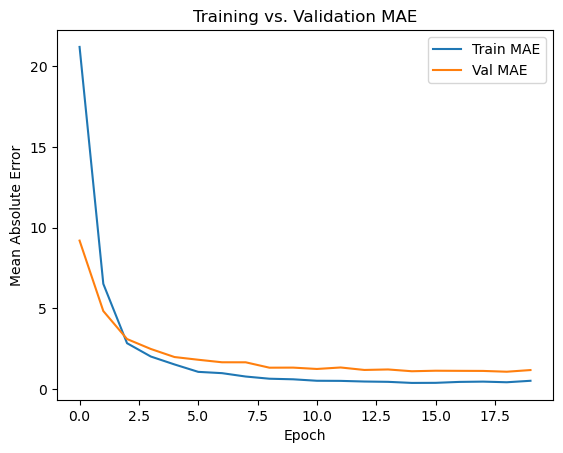

In [16]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

# Plot MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training vs. Validation MAE')
plt.show()


In [22]:
test_loss, test_mae = baseline_model.evaluate(X_test_dict, y_test)
print(f"\nTest Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}\n")

# inverse transform scaled y_test
y_test_orig = y_scaler.inverse_transform(y_test)
y_pred_scaled = baseline_model.predict(X_test_dict)
y_pred_orig = y_scaler.inverse_transform(y_pred_scaled)

# calculate MAE in real units
from sklearn.metrics import mean_absolute_error
real_mae = mean_absolute_error(y_test_orig, y_pred_orig)
print(f"\nTest MAE in real home values: ${real_mae:,.2f}")

y_orig_all = y_scaler.inverse_transform(y)
mean_value = np.mean(y_orig_all)
print(f"Mean Home Value: ${mean_value:,.2f}")

6/6 [==============================] - 0s 777us/step - loss: 1.1130 - mae: 0.4652

Test Loss (MSE): 1.1130
Test MAE: 0.4652

6/6 [==============================] - 0s 656us/step

Test MAE in real home values: $82,017.24
Mean Home Value: $284,427.64


In [26]:
## basic hyperparameter tuning using gridsearch
from sklearn.model_selection import KFold
import itertools

# hyperparameters to search
hidden_units_list = [(32, 32), (64, 64), (128, 128)]
activation_list = ['relu', 'tanh']
optimizer_list = ['adam', 'sgd']
batch_size_list = [16, 32, 64]

# kfold setup (3 splits)
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# store results
grid_results = []

In [27]:
# grid search loop
for hidden_units, activation, optimizer, batch_size in itertools.product(
    hidden_units_list, activation_list, optimizer_list, batch_size_list):
    
    fold_mae_scores = []

    for train_index, val_index in kfold.split(X_train_dict['numerical_input']):
        # split for current fold
        X_fold_train = {col: X_train_dict[col].iloc[train_index] for col in X_train_dict}
        X_fold_val = {col: X_train_dict[col].iloc[val_index] for col in X_train_dict}
        y_fold_train = y_train[train_index]
        y_fold_val = y_train[val_index]

        # build and train model
        model = build_model(hidden_units=hidden_units, activation=activation, optimizer=optimizer)
        model.fit(X_fold_train, y_fold_train,
                  epochs=10, batch_size=batch_size, verbose=0)

        # evaluate on validation fold
        val_loss, val_mae = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        fold_mae_scores.append(val_mae)

    # record mean MAE for this hyperparameter combo
    avg_mae = np.mean(fold_mae_scores)
    grid_results.append({
        'hidden_units': hidden_units,
        'activation': activation,
        'optimizer': optimizer,
        'batch_size': batch_size,
        'val_mae': avg_mae
    })

    print(f"Tested combo: units={hidden_units}, activation={activation}, "
          f"optimizer={optimizer}, batch={batch_size} => Avg MAE: {avg_mae:.4f}")
# convert results to DataFrame
results_df = pd.DataFrame(grid_results)

# save to csv
results_df.to_csv("zillow_grid_search_results.csv", index=False)

Tested combo: units=(32, 32), activation=relu, optimizer=adam, batch=16 => Avg MAE: 1.7291
Tested combo: units=(32, 32), activation=relu, optimizer=adam, batch=32 => Avg MAE: 1.3605
Tested combo: units=(32, 32), activation=relu, optimizer=adam, batch=64 => Avg MAE: 4.5846
Tested combo: units=(32, 32), activation=relu, optimizer=sgd, batch=16 => Avg MAE: nan
Tested combo: units=(32, 32), activation=relu, optimizer=sgd, batch=32 => Avg MAE: nan
Tested combo: units=(32, 32), activation=relu, optimizer=sgd, batch=64 => Avg MAE: nan
Tested combo: units=(32, 32), activation=tanh, optimizer=adam, batch=16 => Avg MAE: 0.5139
Tested combo: units=(32, 32), activation=tanh, optimizer=adam, batch=32 => Avg MAE: 0.4547
Tested combo: units=(32, 32), activation=tanh, optimizer=adam, batch=64 => Avg MAE: 0.4864
Tested combo: units=(32, 32), activation=tanh, optimizer=sgd, batch=16 => Avg MAE: 0.6644
Tested combo: units=(32, 32), activation=tanh, optimizer=sgd, batch=32 => Avg MAE: 0.6531
Tested combo:

In [29]:
# get best hyperparameters from results_df
best_model_row = results_df.sort_values(by='val_mae', ascending=True).iloc[0]  # Lower MAE is better

# extract values
BEST_LAYER_SIZES = best_model_row['hidden_units']
BEST_ACTIVATION = best_model_row['activation']
BEST_BATCH_SIZE = best_model_row['batch_size']
BEST_OPTIMIZER = best_model_row['optimizer']

print("Best Hyperparameters:")
print(f"Layers: {BEST_LAYER_SIZES}, Activation: {BEST_ACTIVATION}, Batch Size: {BEST_BATCH_SIZE}, Optimizer: {BEST_OPTIMIZER}")

Best Hyperparameters:
Layers: (128, 128), Activation: tanh, Batch Size: 32, Optimizer: adam


In [34]:
# rebuild full training input for final model using entire dataset
X_cat_full = {col: X[col].values for col in categorical_cols}
X_num_full = X[numerical_cols].values
X_input_dict_full = {**X_cat_full, 'numerical_input': X_num_full}

In [37]:
# build final model with best hyperparameters
model = build_model(
    hidden_units=BEST_LAYER_SIZES,
    activation=BEST_ACTIVATION,
    optimizer=BEST_OPTIMIZER
)

# train final model on full dataset
model.fit(
    X_input_dict_full, y,
    epochs=10,
    batch_size=BEST_BATCH_SIZE,
    verbose=1
)

# evaluate on test set
test_loss, test_mae = model.evaluate(X_test_dict, y_test, verbose=1)

print(f"\nFinal Test Loss (MSE): {test_loss:.4f}")
print(f"Final Test MAE: {test_mae:.4f}\n")

# convert MAE to real dollar value
y_real_pred = y_scaler.inverse_transform(model.predict(X_test_dict))
y_real_true = y_scaler.inverse_transform(y_test)
real_mae = np.mean(np.abs(y_real_pred - y_real_true))

print(f"\nFinal Test MAE in real home values: ${real_mae:,.2f}")


Epoch 1/10
27/27 [==============================] - 0s 807us/step - loss: 1.1237 - mae: 0.7153
Epoch 2/10
27/27 [==============================] - 0s 768us/step - loss: 0.7945 - mae: 0.5948
Epoch 3/10
27/27 [==============================] - 0s 699us/step - loss: 0.6051 - mae: 0.5255
Epoch 4/10
27/27 [==============================] - 0s 670us/step - loss: 0.4283 - mae: 0.4503
Epoch 5/10
27/27 [==============================] - 0s 679us/step - loss: 0.3385 - mae: 0.3992
Epoch 6/10
27/27 [==============================] - 0s 848us/step - loss: 0.3570 - mae: 0.4109
Epoch 7/10
27/27 [==============================] - 0s 895us/step - loss: 0.3378 - mae: 0.4070
Epoch 8/10
27/27 [==============================] - 0s 877us/step - loss: 0.3090 - mae: 0.4048
Epoch 9/10
27/27 [==============================] - 0s 728us/step - loss: 0.3335 - mae: 0.4288
Epoch 10/10
6/6 [==============================] - 0s 730us/step - loss: 0.1994 - mae: 0.3219

Final Test Loss (MSE): 0.1994
Final Test MAE: 0.32

/var/folders/xw/015f2d5n37g0kf1j6cr6gymh0000gn/T/ipykernel_76772/1109030320.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df_sorted, x='val_mae', y='Config', palette='viridis')


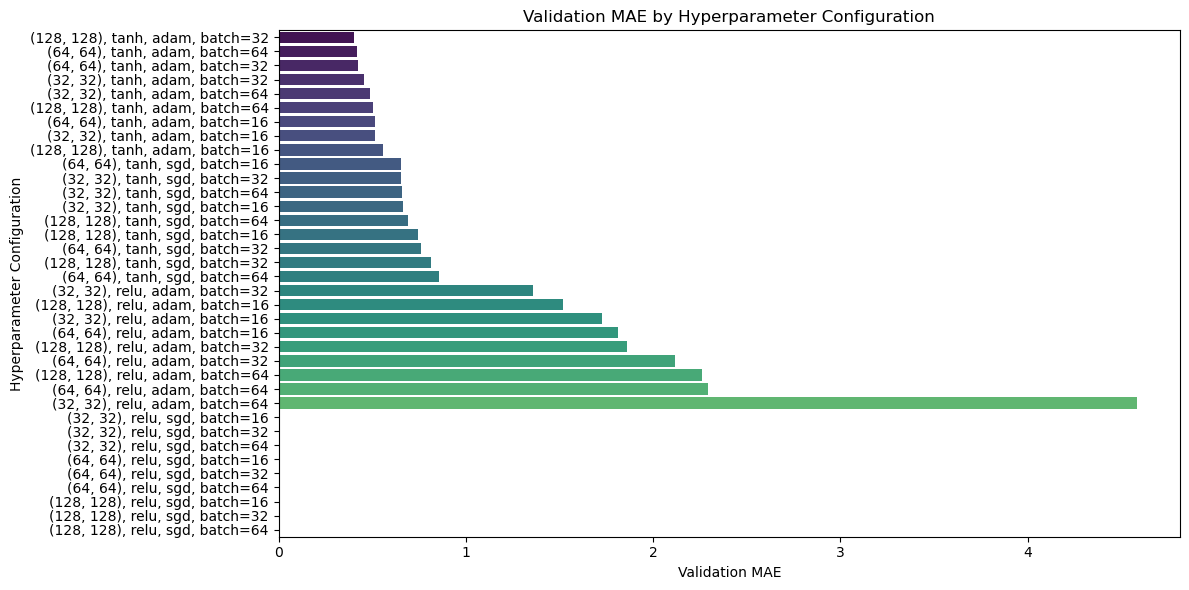

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# sort by validation MAE
results_df_sorted = results_df.sort_values(by='val_mae')

# create a readable label for each row
results_df_sorted['Config'] = results_df_sorted.apply(
    lambda row: f"{row['hidden_units']}, {row['activation']}, {row['optimizer']}, batch={row['batch_size']}", axis=1
)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df_sorted, x='val_mae', y='Config', palette='viridis')
plt.title('Validation MAE by Hyperparameter Configuration')
plt.xlabel('Validation MAE')
plt.ylabel('Hyperparameter Configuration')
plt.tight_layout()
plt.show()


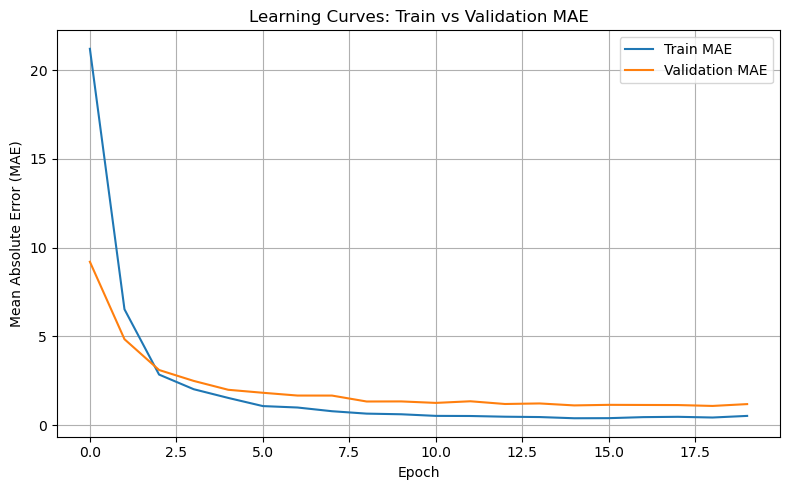

In [39]:
# plot train vs validation MAE from final model's training
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Learning Curves: Train vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


6/6 [==============================] - 0s 778us/step


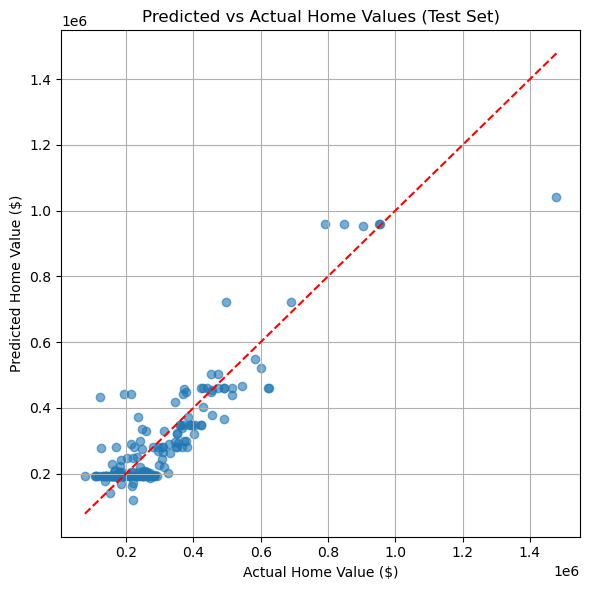

In [40]:
# predict on test set
y_test_pred_scaled = model.predict(X_test_dict)

# inverse transform to real home values
y_test_pred_real = y_scaler.inverse_transform(y_test_pred_scaled)
y_test_real = y_scaler.inverse_transform(y_test)

# scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_real, y_test_pred_real, alpha=0.6)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')  # Diagonal line
plt.title('Predicted vs Actual Home Values (Test Set)')
plt.xlabel('Actual Home Value ($)')
plt.ylabel('Predicted Home Value ($)')
plt.grid(True)
plt.tight_layout()
plt.show()


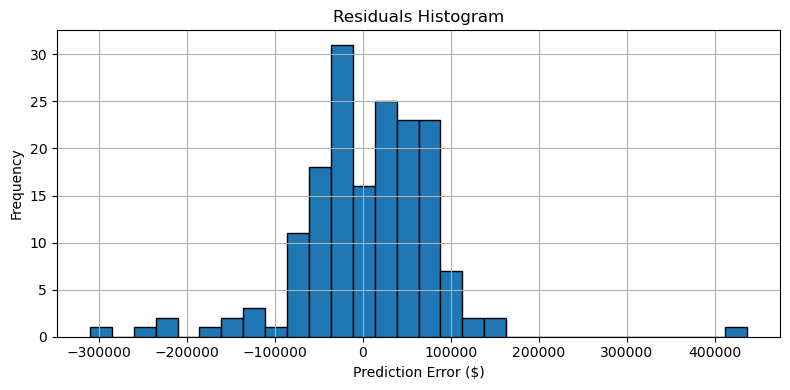

In [41]:
# compute residuals
residuals = y_test_real.flatten() - y_test_pred_real.flatten()

# plot histogram
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Residuals Histogram')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/xw/015f2d5n37g0kf1j6cr6gymh0000gn/T/ipykernel_76772/2315475264.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Layer Size', y='val_mae', errorbar=None, palette='coolwarm')


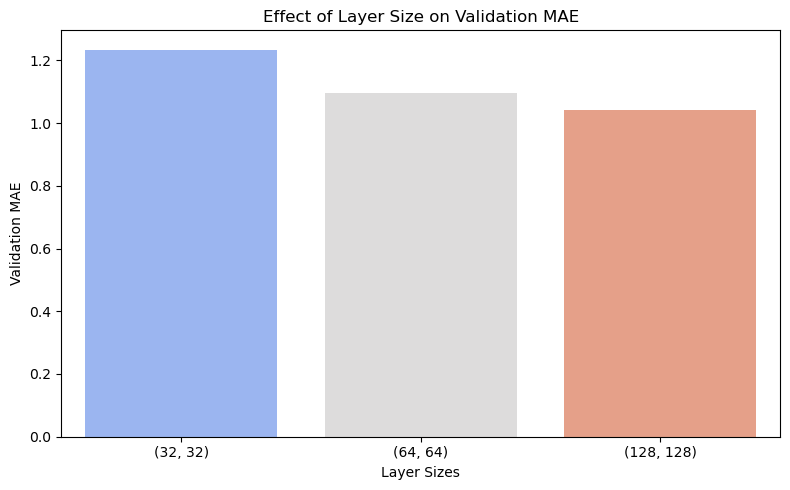

In [44]:
# convert hidden_units from tuple to string for grouping
results_df['Layer Size'] = results_df['hidden_units'].astype(str)

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Layer Size', y='val_mae', errorbar=None, palette='coolwarm')
plt.title('Effect of Layer Size on Validation MAE')
plt.xlabel('Layer Sizes')
plt.ylabel('Validation MAE')
plt.tight_layout()
plt.show()


/var/folders/xw/015f2d5n37g0kf1j6cr6gymh0000gn/T/ipykernel_76772/3185957598.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='activation', y='val_mae', errorbar=None, palette='magma')


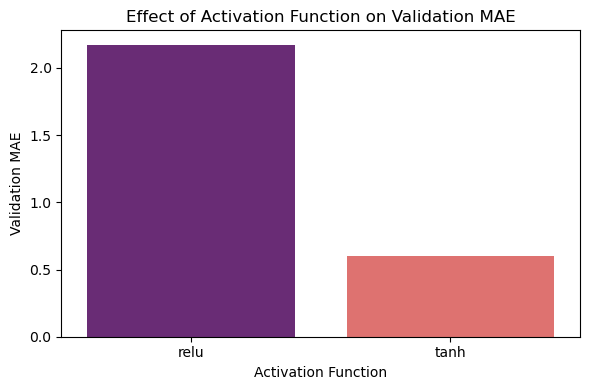

In [46]:
plt.figure(figsize=(6, 4))
sns.barplot(data=results_df, x='activation', y='val_mae', errorbar=None, palette='magma')
plt.title('Effect of Activation Function on Validation MAE')
plt.xlabel('Activation Function')
plt.ylabel('Validation MAE')
plt.tight_layout()
plt.show()


/var/folders/xw/015f2d5n37g0kf1j6cr6gymh0000gn/T/ipykernel_76772/1291084759.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='optimizer', y='val_mae', errorbar=None, palette='cividis')


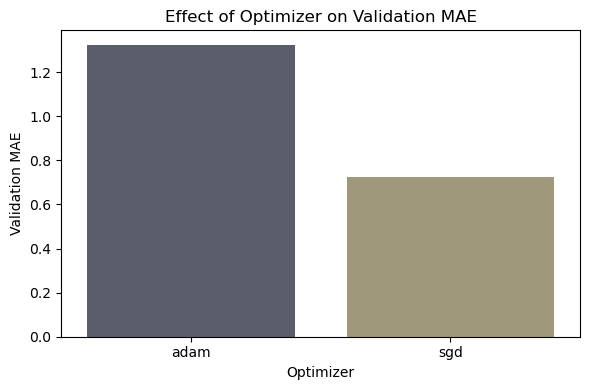

In [48]:
plt.figure(figsize=(6, 4))
sns.barplot(data=results_df, x='optimizer', y='val_mae', errorbar=None, palette='cividis')
plt.title('Effect of Optimizer on Validation MAE')
plt.xlabel('Optimizer')
plt.ylabel('Validation MAE')
plt.tight_layout()
plt.show()


/var/folders/xw/015f2d5n37g0kf1j6cr6gymh0000gn/T/ipykernel_76772/1725071028.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='batch_size', y='val_mae', errorbar=None, palette='plasma')


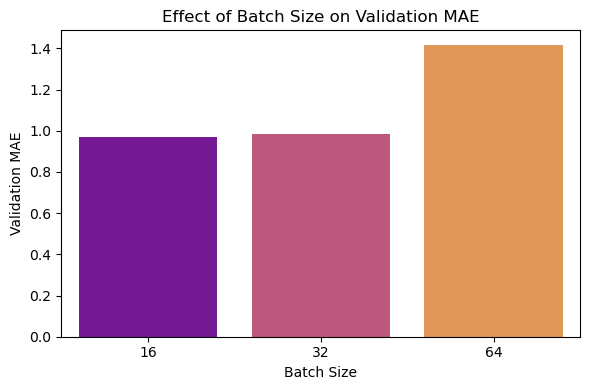

In [49]:
plt.figure(figsize=(6, 4))
sns.barplot(data=results_df, x='batch_size', y='val_mae', errorbar=None, palette='plasma')
plt.title('Effect of Batch Size on Validation MAE')
plt.xlabel('Batch Size')
plt.ylabel('Validation MAE')
plt.tight_layout()
plt.show()
